In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Vechiles.zip"

In [ ]:
!pip install -U torch torchvision -f "https://download.pytorch.org/whl/cu101/torch_stable.html"
!pip install cython pyyaml
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git
!python -m pip install -e detectron2

In [ ]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)


from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
register_coco_instances("vehicle_train", {}, "/content/train/_annotations.coco.json", "/content/train/")
register_coco_instances("vehicle_valid", {}, "/content/valid/_annotations.coco.json", "/content/valid/")
register_coco_instances("vehicle_test", {}, "/content/test/_annotations.coco.json", "/content/test/")

WARNING [10/27 16:07:41 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/27 16:07:41 d2.data.datasets.coco]: Loaded 1924 images in COCO format from /content/train/_annotations.coco.json


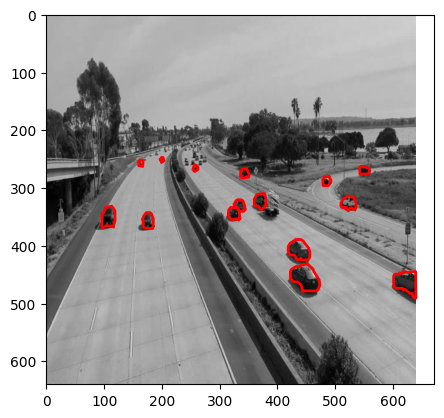

In [ ]:
dataset_train = DatasetCatalog.get("vehicle_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vehicle_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("vehicle_valid",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 3000 #We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = [300,]
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 # 26 letters plus one super class
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training

PATIENCE = 500 #Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True) # Model Sonucu İçin Klasör Oluşturur
trainer = DefaultTrainer(cfg) # Modeli Train Moduna Geçirir Yapılandırma Dosyası ile Birlikte
trainer.resume_or_load(resume=False) # Model Eğitimine 0'dan Başlamak İçin False Yapıyoruz


trainer.train() # Model Eğitimine Başlar



[10/27 18:25:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[10/27 18:25:52 d2.engine.train_loop]: Starting training from iteration 0
[10/27 18:26:20 d2.utils.events]:  eta: 1:08:40  iter: 19  total_loss: 2.941  loss_cls: 1.745  loss_box_reg: 0.4349  loss_mask: 0.6893  loss_rpn_cls: 0.0508  loss_rpn_loc: 0.02689    time: 1.3835  last_time: 1.5276  data_time: 0.0122  last_data_time: 0.0047   lr: 7.2025e-06  max_mem: 6299M
[10/27 18:26:46 d2.utils.events]:  eta: 1:08:09  iter: 39  total_loss: 2.531  loss_cls: 1.608  loss_box_reg: 0.2332  loss_mask: 0.6785  loss_rpn_cls: 0.03908  loss_rpn_loc: 0.007095    time: 1.3446  last_time: 1.0281  data_time: 0.0048  last_data_time: 0.0043   lr: 1.2152e-05  max_mem: 6299M
[10/27 18:27:12 d2.utils.events]:  eta: 1:04:59  iter: 59  total_loss: 2.496  loss_cls: 1.385  loss_box_reg: 0.3883  loss_mask: 0.6609  loss_rpn_cls: 0.05334  loss_rpn_loc: 0.01985    time: 1.3129  last_time: 1.2855  data_time: 0.0045  last_data_time: 0.0050   lr: 1.7103e-05  max_mem: 6299M
[10/27 18:27:37 d2.utils.events]:  eta: 1:04:32  i

In [ ]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

evaluator = COCOEvaluator("vehicle_valid", cfg, False, output_dir=cfg.OUTPUT_DIR) # COCO Evaluator oluşturun
data_loader = build_detection_test_loader(cfg, "vehicle_valid") # Test veri yükleyici oluşturun
# Testi başlatın
print(inference_on_dataset(trainer.model, data_loader, evaluator))

WARNING [10/27 19:37:00 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [10/27 19:37:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/27 19:37:00 d2.data.datasets.coco]: Loaded 734 images in COCO format from /content/valid/_annotations.coco.json
[10/27 19:37:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/27 19:37:00 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/27 19:37:00 d2.data.common]: Serializing 734 elements to byte tensors and concatenating them all ...
[10/27 19:37:00 d2.data.common]: Serialized dataset takes 1.55 MiB
[10/27 19:37:00 d2.evaluation.evaluator]: Start inference on 734 batches
[10/27 19:37:02 d2.evaluation.eval

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("vehicle_test")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im = Image.fromarray(out.get_image()[:, :, ::-1])
    im

[10/27 19:49:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [10/27 19:49:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/27 19:49:20 d2.data.datasets.coco]: Loaded 665 images in COCO format from /content/test/_annotations.coco.json


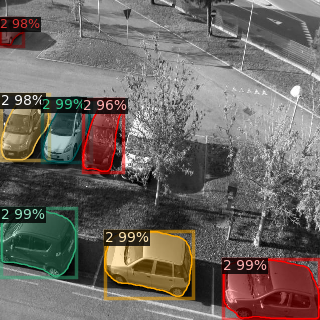

In [ ]:
im

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vehicle_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("vehicle_valid",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 3000 #We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = [300,]
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 # 26 letters plus one super class
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

cfg.merge_from_list(["MODEL.WEIGHTS", "weights.pth"])   # can also load values from a list of str
print(cfg.dump())  # print formatted configs
with open("output.yaml", "w") as f:
  f.write(cfg.dump())   # save config to file

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - vehicle_valid
  TRAIN:
  - vehicle_train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resne

In [ ]:
!git clone https://github.com/facebookresearch/detectron2

In [ ]:
%run detectron2/demo/demo.py --config-file /content/output.yaml --video-input /content/drive/MyDrive/kusbakis.mp4 --confidence-threshold 0.58 --output video-output.mp4 \
  --opts MODEL.WEIGHTS /content/drive/MyDrive/weights/model_final.pth

[10/28 16:40:48 detectron2]: Arguments: Namespace(config_file='/content/output.yaml', webcam=False, video_input='/content/drive/MyDrive/kusbakis.mp4', input=None, output='video-output.mp4', confidence_threshold=0.58, opts=['MODEL.WEIGHTS', '/content/drive/MyDrive/weights/model_final.pth'])
[10/28 16:40:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/weights/model_final.pth ...
[10/28 16:40:50 fvcore.common.checkpoint]: [Checkpointer] Loading from /content/drive/MyDrive/weights/model_final.pth ...


100%|██████████| 949/949 [25:02<00:00,  1.58s/it]


In [ ]:
from google.colab import files
files.download('/content/video-output.mp4')

In [ ]:
from google.colab import files
files.download('/content/output/model_final.pth')